In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import torch
plt.style.use('seaborn-whitegrid')

/tmp/ipykernel_567489/2724499362.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [2]:
# results_dir = "cifar_task_specific_proj_results"
# results_dir = "grad_new_results"
# results_dir = "cifar_no_updates_contrastive_results"
results_dir = "cifar_epochs_500_mild_dropout_memory_64_data_300_results"
# use_contrastive = True

# results_dir = "vanilla_results"
use_contrastive = False

algo = "modular"
# algo = "monolithic"
dataset = "cifar100"
# dataset = "mnist"
agent = "agent_3"
# seed = "seed_2"
seed = "seed_0"
# numtrain = 256
numtrain = 300
# numtrain = 64
job = f"{dataset}_{algo}_numtrain_{numtrain}"
if use_contrastive:
    job += "_contrastive"
path = os.path.join(results_dir, job, dataset, algo, seed, agent)

In [3]:
df = pd.read_csv(os.path.join(path, "record.csv"))
df.head()

,train_task,test_task,test_acc,test_loss,epoch
0,0,0,0.2,1.610188,0
1,0,avg,0.2,1.610188,0
2,0,0,0.2,1.610188,0
3,0,avg,0.2,1.610188,0
4,1,0,0.2,1.610188,0


In [4]:
df["train_task"].dtype

dtype('int64')

In [5]:
# # throw away train_task that cannot be converted to int
# df = df[df["train_task"].apply(lambda x: x.isnumeric())]
# df["train_task"] = df["train_task"].astype(int)

In [6]:
max_task = int(pd.to_numeric(df["train_task"], errors="coerce").max())
max_task

19

In [7]:
def get_magma_colors(total_elements):
    start = 0.2
    stop = 0.8
    cm_subsection = np.linspace(start, stop, total_elements)
    return [matplotlib.cm.plasma(x) for x in cm_subsection]

Text(0, 0.5, 'accuracy')

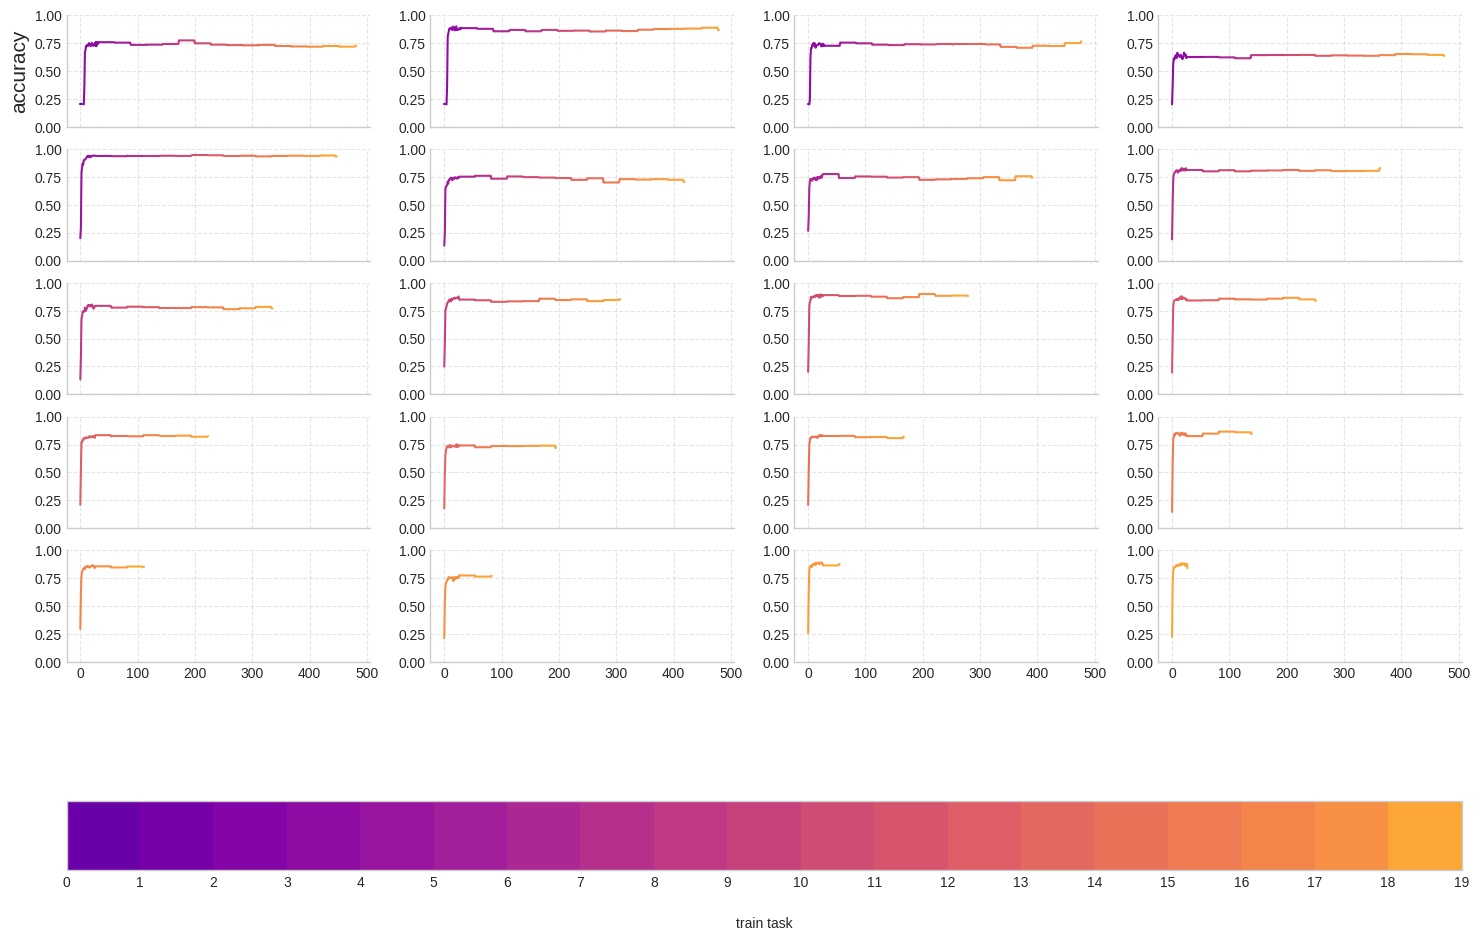

In [8]:
fig, axs = plt.subplots(figsize=(18, 12), nrows=5, ncols=4, sharex=True, sharey=False)
axs = axs.ravel()

colors = get_magma_colors(max_task+1)
for task in range(max_task+1):
    ax = axs[task]
    task_df = df[df["test_task"] == str(task)]
    # re-index the task_df
    task_df = task_df.reset_index(drop=True)
    # create "time" column from index
    task_df["time"] = task_df.index
    # create custom color map from magma

    # plot test_acc vs time colored by train_task
    # using magma discrete colormap
    for train_task in range(max_task+1):
        train_task_df = task_df[task_df["train_task"] == train_task]
        ax.plot(train_task_df["time"], train_task_df["test_acc"], color=colors[train_task], label=f"train_task={train_task}")

    ax.grid(True, which='major', linestyle='--', alpha=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # set y limit between 0 and 1
    ax.set_ylim(0, 1)


# display discrete colorbar from the colors list
# https://stackoverflow.com/questions/33689976/how-to-create-a-discrete-colorbar-in-matplotlib
cmap = matplotlib.colors.ListedColormap(colors)
bounds = np.arange(0, max_task+1)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axs, ticks=bounds, boundaries=bounds, spacing='proportional', orientation='horizontal')
cbar.ax.set_xticklabels([str(i) for i in range(max_task+1)])
cbar.set_label("train task", rotation=0, labelpad=20)

# labels y as accuracy
axs[0].set_ylabel("accuracy", fontsize=15)

In [9]:
# need to create a "running" epochs column, which is the sum of epochs for each train_task
# cumsum for every "n" rows
df["time"] = df.index

/tmp/ipykernel_567489/3139382517.py:24: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=bounds, boundaries=bounds, spacing='proportional', orientation='horizontal')


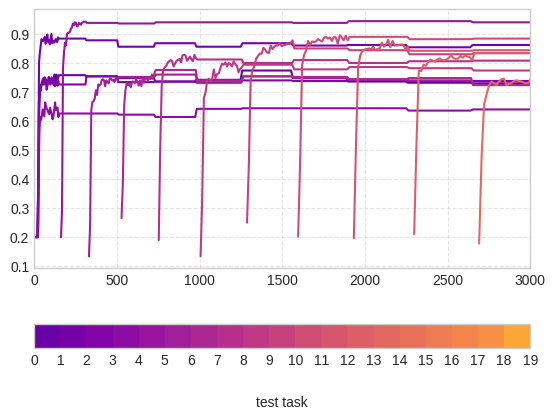

In [10]:
# for each task, plot the test_acc vs time colored by the task,
# starting with when train_task == test_task onwards (in one plot)
# colors in tab20
# colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
#             "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5", "#c49c94", "#f7b6d2", "#c7c7c7", "#dbdb8d", "#9edae5"]
for task in range(max_task+1):
# for task in range(0, 5):
# for task in range(19, 20):
    task_df = df[df["train_task"] >= task]
    # get task_df of only test_task == task
    task_df = task_df[task_df["test_task"] == str(task)]
    # smooth out the test_acc
    # task_df["test_acc"] = task_df["test_acc"].rolling(5).mean()
    plt.plot(task_df["time"], task_df["test_acc"], label=f"test_task={task}",
             color=colors[task],)
plt.grid(True, which='major', linestyle='--', alpha=0.5)
plt.xlim(0, 3000)
# add colorbar
cmap = matplotlib.colors.ListedColormap(colors)
bounds = np.arange(0, max_task+1)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ticks=bounds, boundaries=bounds, spacing='proportional', orientation='horizontal')
cbar.ax.set_xticklabels([str(i) for i in range(max_task+1)])
cbar.set_label("test task", rotation=0, labelpad=20)

In [11]:
from shell.utils.metric import Metric
# m = Metric(path, num_init_tasks=4, num_init_epochs=500, num_epochs=200)
m = Metric(path, num_init_tasks=4, num_init_epochs=100, num_epochs=100)

In [12]:
m.compute_final_accuracy(reduce=None)

,train_task,test_task,test_acc,test_loss,epoch
5744,19,0,0.7180,0.700780,501
5745,19,1,0.8880,0.375129,501
5746,19,2,0.7500,0.742997,501
5747,19,3,0.6440,0.936415,501
5748,19,4,0.9420,0.208360,501
5749,19,5,0.7240,0.761804,501
5750,19,6,0.7560,0.765468,501
5751,19,7,0.8040,0.584735,501
5752,19,8,0.7840,0.628362,501
5753,19,9,0.8460,0.422596,501


In [13]:
m.compute_avg_accuracy(reduce=None)

,train_task,test_task,test_acc,test_loss,epoch
52,3,avg,0.748000,0.747562,501
157,3,avg,0.748500,0.692791,501
199,4,avg,0.778800,0.876578,501
325,4,avg,0.790000,0.848443,501
374,5,avg,0.776000,0.711718,501
521,5,avg,0.774667,0.717211,501
577,6,avg,0.768000,0.674300,501
745,6,avg,0.775714,0.661065,501
808,7,avg,0.778750,0.652316,501
997,7,avg,0.774750,0.667978,501


In [ ]:
pd.read_csv(os.path.join(path, "add_modules_record.csv"))

In [ ]:
# load the net checkpoint to see the architecture
checkpt = torch.load(os.path.join(path, "task_19", "checkpoint.pt"))
net = checkpt['model_state_dict']

In [ ]:
from pprint import pprint
pprint(net.keys())

In [ ]:
fig, axs = plt.subplots(figsize=(20, 5), nrows=5, ncols=4, sharex=True, sharey=False)
axs = axs.ravel()
for task in range(max_task+1):
# for task in range(1):
    # ax = axes[task]
    struct = net[f'structure.{task}'].cpu()
    # softmax the structure
    struct = torch.nn.functional.softmax(struct, dim=0)
    # ax = fig.add_subplot(20, 1, task+1)
    ax = axs[task]
    ax.imshow(struct)
    ax.axis("off")
    ax.set_title(f"Task {task}")

In [ ]:
struct.shape

In [ ]:
net['projector.19.2.weight'].shape